In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [137]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


# I added this because I prefer print data straight into a dataframe then the SQL code in Jupyter Notebooks
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
Measurement_row = session.query(Measurement).first()
Measurement_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x148ed9b27b8>,
 'station': 'USC00519397',
 'id': 1,
 'tobs': 65.0,
 'date': '2010-01-01',
 'prcp': 0.08}

In [11]:
Station_row = session.query(Station).first()
Station_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x148eda3a5c0>,
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

# Exploratory Climate Analysis

In [12]:
# # Design a query to retrieve the last 12 months of precipitation data and plot the results
# measurement_list = engine.execute('select * from Measurement').fetchall()
# Measurement = pd.DataFrame(measurement_list)
# # Had to do some massaging of the colums to get it right
# del Measurement[0]
# Measurement.columns=['Station ID','Date','Precip','Temp'] 
# Measurement = Measurement.tail(365)
# Measurement
# # I get it you can ding me for 12 months versus 365 days but this is efficient



In [13]:
engine.execute('select date from Measurement').first()

('2010-01-01',)

In [14]:
# Calculate the date 1 year ago from the last data point in the database
lastDate = engine.execute('select date from Measurement ORDER BY date DESC').first()
str(lastDate)
print(type(lastDate))
date_object = dt.datetime.strptime('2017-08-23', '%Y-%m-%d').date()
date_object

# here's what I would have done if I could get the type to become a string
# lastDateMinus12 = dt.date.today() - dt.timedelta(days=365)
# lastDateMinus12
# print(lastDateMinus12)


<class 'sqlalchemy.engine.result.RowProxy'>


datetime.date(2017, 8, 23)

In [110]:
# Perform a query to retrieve the data and precipitation scores

# I wrote this query before finding the date from above.  It's clever and cleaner so I keeping it in
measurement_list = engine.execute('select * from Measurement WHERE date >= "2016-08-23" ORDER BY date DESC').fetchall()
measurement_list

[(2724, 'USC00519397', '2017-08-23', 0.0, 81.0),
 (7635, 'USC00514830', '2017-08-23', 0.0, 82.0),
 (12187, 'USC00519523', '2017-08-23', 0.08, 82.0),
 (19550, 'USC00516128', '2017-08-23', 0.45, 76.0),
 (2723, 'USC00519397', '2017-08-22', 0.0, 82.0),
 (12186, 'USC00519523', '2017-08-22', 0.0, 82.0),
 (19549, 'USC00516128', '2017-08-22', 0.5, 76.0),
 (2722, 'USC00519397', '2017-08-21', 0.0, 81.0),
 (7634, 'USC00514830', '2017-08-21', 0.02, 79.0),
 (12185, 'USC00519523', '2017-08-21', None, 82.0),
 (19548, 'USC00516128', '2017-08-21', 0.56, 76.0),
 (2721, 'USC00519397', '2017-08-20', 0.0, 81.0),
 (7633, 'USC00514830', '2017-08-20', 0.01, 80.0),
 (19547, 'USC00516128', '2017-08-20', None, 78.0),
 (2720, 'USC00519397', '2017-08-19', 0.0, 79.0),
 (7632, 'USC00514830', '2017-08-19', 0.0, 80.0),
 (12184, 'USC00519523', '2017-08-19', None, 85.0),
 (19546, 'USC00516128', '2017-08-19', 0.09, 71.0),
 (2719, 'USC00519397', '2017-08-18', 0.0, 80.0),
 (7631, 'USC00514830', '2017-08-18', 0.0, 77.0),
 (

In [116]:
# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.DataFrame(measurement_list)
del measurement_df[0]
measurement_df.columns=['Station ID','Date','Precip','Temp'] 
del measurement_df['Station ID']
del measurement_df['Temp']

#measurement_df.set_index('Date').groupby(pd.Grouper(freq='D')).mean()
#measurement_df.resample('D', on='Date').mean()

measurement_df
# measurement_pd.set_index('Date')

,Date,Precip
0,2017-08-23,0.00
1,2017-08-23,0.00
2,2017-08-23,0.08
3,2017-08-23,0.45
4,2017-08-22,0.00
...,...,...
2225,2016-08-23,0.05
2226,2016-08-23,NaN
2227,2016-08-23,0.02
2228,2016-08-23,1.79


In [117]:
# Sort the dataframe by date

# Already did this through sorting the data in my query

In [127]:
# dropping NaN values
measurement_df = measurement_df[measurement_df['Precip'].notna()]
measurementGrouped = measurement_df.groupby("Date")
# print(len(measurement_df))
print(len(measurementGrouped))

# props to https://technology.amis.nl/2019/10/11/convert-groupby-result-on-pandas-data-frame-into-a-data-frame-using-to_frame/
# I struggled with this for so long and it seems so crucial to data manipulation
measureGrouped_df = measurementGrouped['Precip'].mean().to_frame(name = 'Precip').reset_index()
print(len(measureGrouped_df))
measureGrouped_df


366
366


,Date,Precip
0,2016-08-23,0.451667
1,2016-08-24,1.555000
2,2016-08-25,0.077143
3,2016-08-26,0.016667
4,2016-08-27,0.064000
...,...,...
361,2017-08-19,0.030000
362,2017-08-20,0.005000
363,2017-08-21,0.193333
364,2017-08-22,0.166667


In [128]:
# credit to https://matplotlib.org/3.2.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
# Organing by month. Turns out I didn't need it becaues I used pd.Period later by I liked it and left it in
# measurement_df['Month'] = pd.to_datetime(measurement_df['Date']).dt.to_period('M')

In [129]:
# Use Pandas Plotting with Matplotlib to plot the data
# measurement_pd[["Month","Precip"]].plot.bar()
# plt.show()

months = measureGrouped_df['Date'].sort_values()
startmonth = months.iloc[0]
index = pd.date_range(startmonth, periods = 3, freq = 'M')
index

# measurement_pd.groupby('Month')['model'].count().reindex(index).plot.bar();
# xticks(index)

DatetimeIndex(['2016-08-31', '2016-09-30', '2016-10-31'], dtype='datetime64[ns]', freq='M')

In [172]:
# This is test code
# measureGrouped_df.plot(x='Date', y='Precip')


[Text(0, 0, '2016-08-23'),
 Text(0, 0, '2016-09-22'),
 Text(0, 0, '2016-10-22'),
 Text(0, 0, '2016-11-21'),
 Text(0, 0, '2016-12-21'),
 Text(0, 0, '2017-01-20'),
 Text(0, 0, '2017-02-19'),
 Text(0, 0, '2017-03-21'),
 Text(0, 0, '2017-04-20'),
 Text(0, 0, '2017-05-20'),
 Text(0, 0, '2017-06-19'),
 Text(0, 0, '2017-07-19'),
 Text(0, 0, '2017-08-18')]

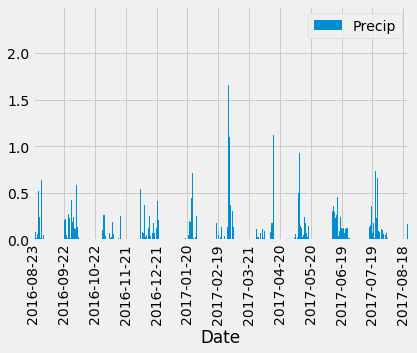

In [131]:
# Citation to https://stackoverflow.com/questions/19143857/pandas-bar-plot-xtick-frequency
n = 30

ax = measureGrouped_df.plot(kind='bar', x='Date', y='Precip')
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
ax.xaxis.set_ticklabels(ticklabels[::n])


In [132]:
# My graph looks different from the one in the instructions but I would say this is a correct look at it

# As I am unsure what calucations were used in the example I went with the mean precipitation from all 
# available stations

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [133]:
# Use Pandas to calcualte the summary statistics for the precipitation data

In [142]:
# Design a query to show how many stations are available in this dataset?
# station_data= engine.execute('select COUNT ( DISTINCT station ) AS "Stations" from Station').fetchall()
# station_data

numStations = pd.read_sql('SELECT COUNT ( DISTINCT station ) AS "Stations" from Station', conn)
numStations


,Stations
0,9


In [155]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
    
# station_data= engine.execute('SELECT station COUNT(*) FROM Station GROUP BY station').fetchall()

dataFromStations = pd.read_sql('SELECT station, COUNT(*) FROM Measurement GROUP BY station', conn)
dataFromStations.columns=['Station ID','Count']
dataFromStations.sort_values('Count')

,Station ID,Count
5,USC00518838,511
4,USC00517948,1372
0,USC00511918,1979
2,USC00514830,2202
3,USC00516128,2612
8,USC00519523,2669
1,USC00513117,2709
7,USC00519397,2724
6,USC00519281,2772


In [166]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
dataActiveStation = pd.read_sql('SELECT MIN(tobs), MAX(tobs), AVG(tobs) FROM Measurement WHERE station="USC00519281"', conn)
dataActiveStation.columns=['Min Temp @ WAIHEE (F)','Max Temp @ WAIHEE (F)','Avg Temp @ WAIHEE (F)']
dataActiveStation

,Min Temp @ WAIHEE (F),Max Temp @ WAIHEE (F),Avg Temp @ WAIHEE (F)
0,54.0,85.0,71.663781


Text(0.5, 1.0, 'Temperatures at WAIHEE over the year')

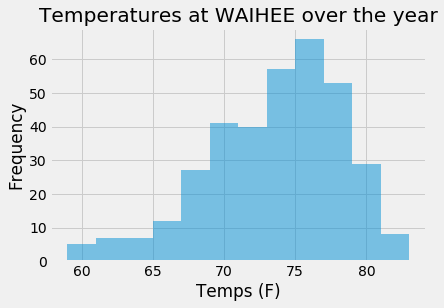

In [171]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tempDataActiveStation = pd.read_sql('SELECT * FROM Measurement WHERE station="USC00519281" AND date >= "2016-08-23"', conn)
tempDataActiveStation

ax = tempDataActiveStation["tobs"].plot.hist(bins=12, alpha=0.5)
ax.set_xlabel("Temps (F)")
ax.set_title("Temperatures at WAIHEE over the year")


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
